# (IGNORE - Moved to Client and Server) Outfit Generation
- Take in an image and return a style board

In [2]:
import json
import numpy as np
import numpy.linalg as la
import torch

from IPython.display import display
from PIL import Image
from rembg import remove

import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from transformers import AutoModelForImageClassification, AutoImageProcessor

### Load in embeddings and models

In [3]:
# Data paths
data_dir = "../polyvore_outfits/"

embeddings_path = data_dir + "embeddings.npy"
filenames_path = data_dir + "filenames.txt"
images_path = data_dir + "images/"
item_metadata_path = data_dir + "item_metadata.json"
outfits_metadata_path = data_dir + "outfits_metadata.json"
categories_path = data_dir + "categories.csv"
local_categories_path = data_dir + "local_category_map.json"


In [4]:
# Load in embeddings
embeddings = np.load(embeddings_path)
filenames_file = open(filenames_path, 'r')
filenames = [line.strip() for line in filenames_file.readlines()]

# Error checking
if len(embeddings) != len(filenames):
    print("STOP. The lengths of embeddings and filenames don't match")
    print(len(embeddings), len(filenames))

In [5]:
# Load in outfits
outfits_file = open(outfits_metadata_path, 'r')
outfit_map = json.load(outfits_file)

items_file = open(item_metadata_path, 'r')
items_map = json.load(items_file)

In [6]:
# Load in categories
categories_file = open(categories_path)
category_map = {}
for line in categories_file:
    parts = line.strip().split(',')
    category_map[int(parts[0])] = tuple(parts[1:])

# Mapping from local to server categories
local_category_file = open(local_categories_path, 'r')
local_to_server_category_map = json.load(local_category_file)

# Error Checking
for key, value in local_to_server_category_map.items():
    for key2 in value['mapping']:
        if key2 not in category_map:
            print(category_map)
            print(key2, "is a Missing category")


In [7]:
# Inverted index from image to boards they are part of
item_to_outfits = {}

for outfit_id, metadata in outfit_map.items():
    for item in metadata['items']:
        item_id = item['item_id']
        item_to_outfits[item_id] = item_to_outfits.get(item_id, []) + [outfit_id]

In [8]:
# Local Clothing Classification Model
item_classifier_path = "../item_model/"

# Load the model - Note download `model/tf_mode.h5` at https://huggingface.co/aalonso-developer/vit-base-patch16-224-in21k-clothing-classifier/tree/main
item_model = AutoModelForImageClassification.from_pretrained(
    item_classifier_path,
    from_tf=True,  # Indicates that the model weights are in TensorFlow format
    config="config.json"  # Provide the path to the config.json file
)

id2label = item_model.config.id2label

# Load the image processor
item_processor = AutoImageProcessor.from_pretrained(
    item_classifier_path,
    preprocess_config="preprocess_config.json"  # Provide the path to preprocess_config.json
)

torch.device('cpu')


All TF 2.0 model weights were used when initializing ViTForImageClassification.

All the weights of ViTForImageClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use ViTForImageClassification for predictions without further training.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


device(type='cpu')

In [9]:
# Embedding model
emb_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
emb_model.trainable = False
emb_model = Sequential([emb_model, GlobalMaxPooling2D()])

### Narrow Scope of Color Inference

### Run Local Inference Models

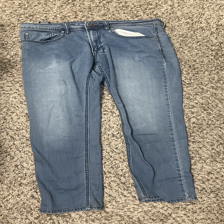

In [10]:
def remove_background(image_path):
    try:
        img = Image.open(image_path)
        img_without_bg = remove(img)
        return img_without_bg.resize((224, 224)).convert("RGB")
    except Exception as e:
        print(f"Error removing background: {e}")
        return None
    
# Get clothing classification
def classify_item_type(image, threshold=0.15):
    # Process image
    inputs = item_processor(images=image, return_tensors="pt", format="channels_first")

    # Perform inference using the loaded model
    outputs = item_model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).detach()
    topk = torch.topk(probs, 5)

    # Readable format
    clothing_embedding = [id2label[int(idx)] for idx in topk.indices[0]]

    # Add above a threshold
    return_embeddings, return_probs = [], []
    for i, probability in enumerate(topk.values[0]):
        if probability > threshold:
            return_embeddings.append(clothing_embedding[i])
            return_probs.append(float(probability))

    # At least one category is chosen
    if len(return_embeddings) == 0:
        return_embeddings.append(clothing_embedding[0])
        return_probs.append(int(topk.values[0][0]))

    display(image)

    return return_embeddings, return_probs
    
ex_img = "jeans.png"
# image = remove_background(ex_img)

# No remove image background
img = Image.open(ex_img)
image = img.resize((224, 224)).convert("RGB")
item_categories, probabilities = classify_item_type(image)

In [11]:
def get_embeddings(img):
    # Normalize image
    img_array = kimage.img_to_array(img)
    expand_img = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expand_img)

    # Run prediction
    result_to_resnet = emb_model.predict(preprocessed_img)
    print(result_to_resnet.shape)
    flatten_result = result_to_resnet.flatten()
    result_normalized = flatten_result / la.norm(flatten_result)

    return result_normalized

img_embeddings = get_embeddings(image)

print(img_embeddings.shape)
img_embeddings

(1, 2048)
(2048,)


array([0.02651525, 0.073531  , 0.        , ..., 0.        , 0.00534359,
       0.01297403], dtype=float32)

### Narrow Search by finding intersection for the color and clothing identifier

### Run nearest neighbors on intersection

In [13]:
# Create nearest neighbor search for embeddings
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(embeddings)
distance, indices = neighbors.kneighbors([img_embeddings])

In [14]:
def displayBoard(key):
    # Size hyperparameters
    num_items = len(outfit_map[key]['items'])
    image_width = 1000

    # Conglomerated info
    concatenated_image = np.zeros((image_width, 0, 3), dtype=np.uint8)
    item_descriptions = []
        
    # print("Title:", outfit_map[key]['title'])

    for ids in outfit_map[key]['items']:
        # Get the image
        path = "../polyvore_outfits/images/" + ids['item_id'] + ".jpg"
        image = Image.open(path)

        # Resize
        image = image.resize((image_width, image_width), Image.LANCZOS)
        image_array = np.array(image)
        concatenated_image = np.concatenate((concatenated_image, image_array), axis=1)

        description = items_map[ids['item_id']]['url_name'] + " (" + items_map[ids['item_id']]['semantic_category'] + ")"
        item_descriptions.append(description)

    # Display board
    plt.figure(figsize=(image_width * num_items / 100, image_width / 100))  # Adjusted figure size
    plt.imshow(concatenated_image)
    plt.axis('off')

    # plt.savefig(outfit_map[key]['title'])
    plt.show()

    # print("Items:", item_descriptions)

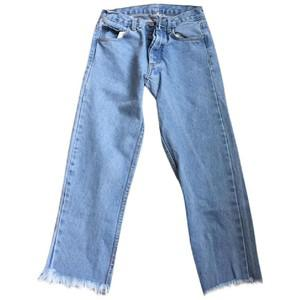

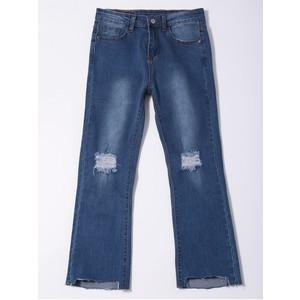

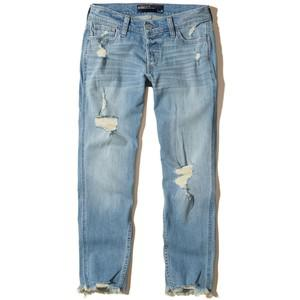

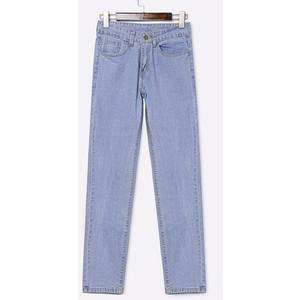

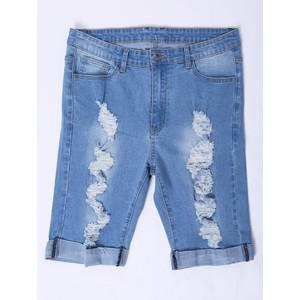

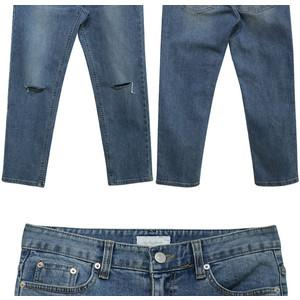

In [15]:
boards = []
for file_idx in indices[0]:
    img = Image.open(images_path + filenames[file_idx])
    img_path = filenames[file_idx][:-4]
    img_board = item_to_outfits.get(img_path, [])
    boards.extend(img_board)
    
    # img.save(str(file_idx) + ".png")
    display(img)

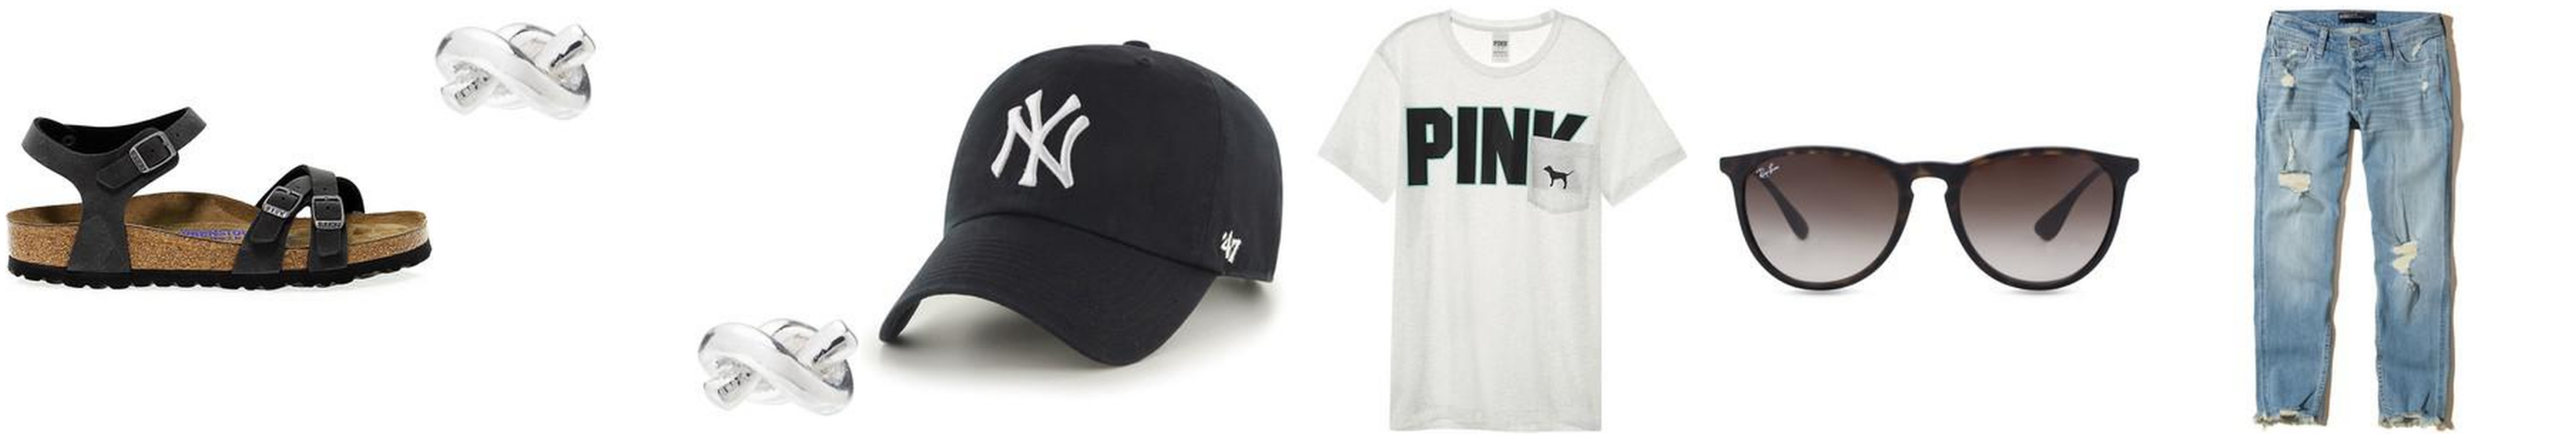

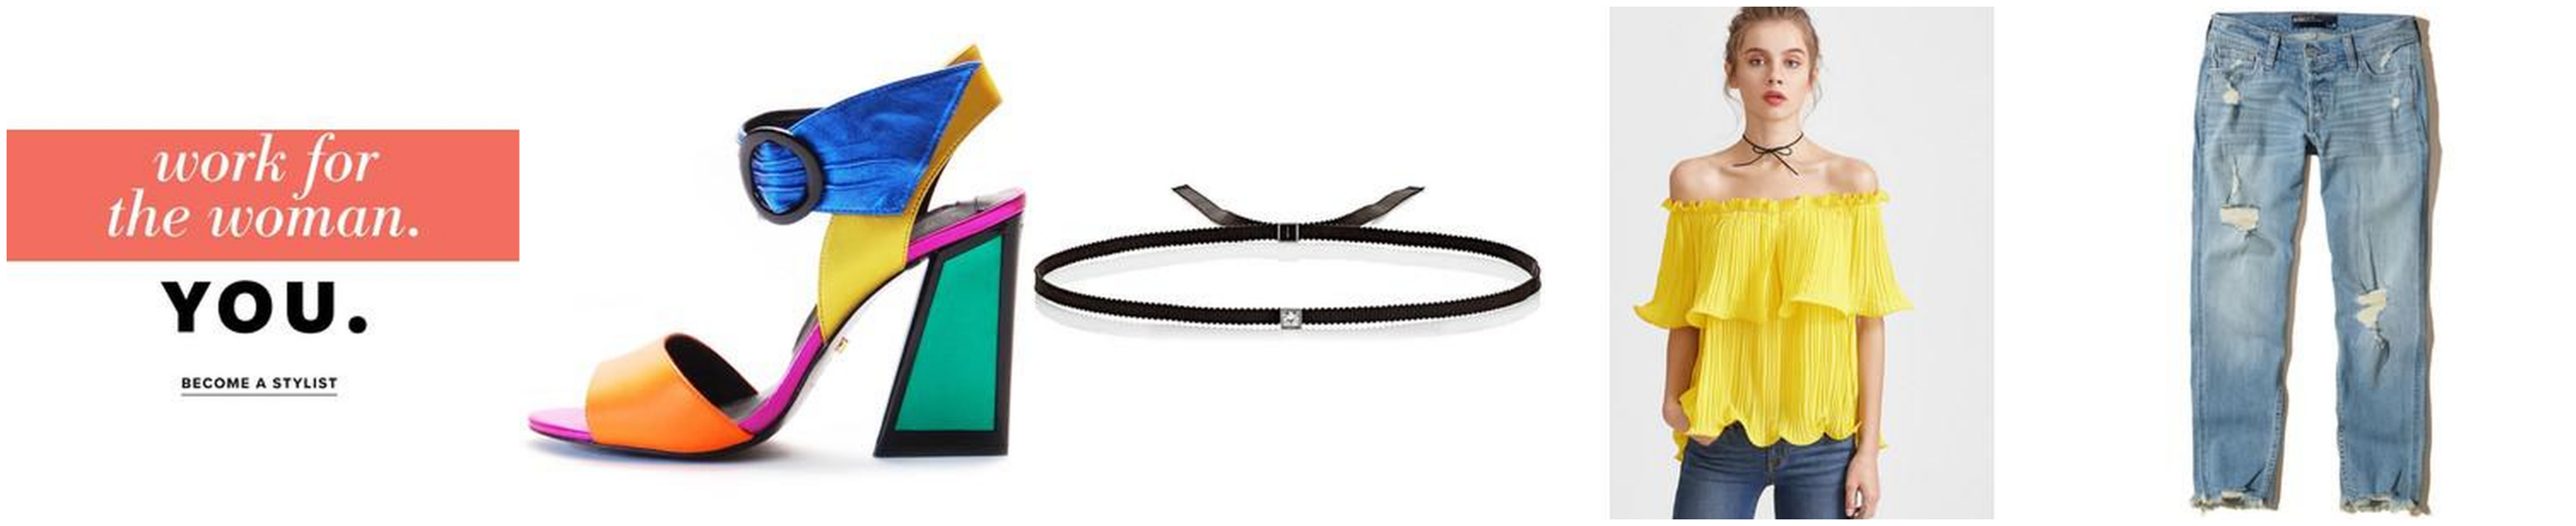

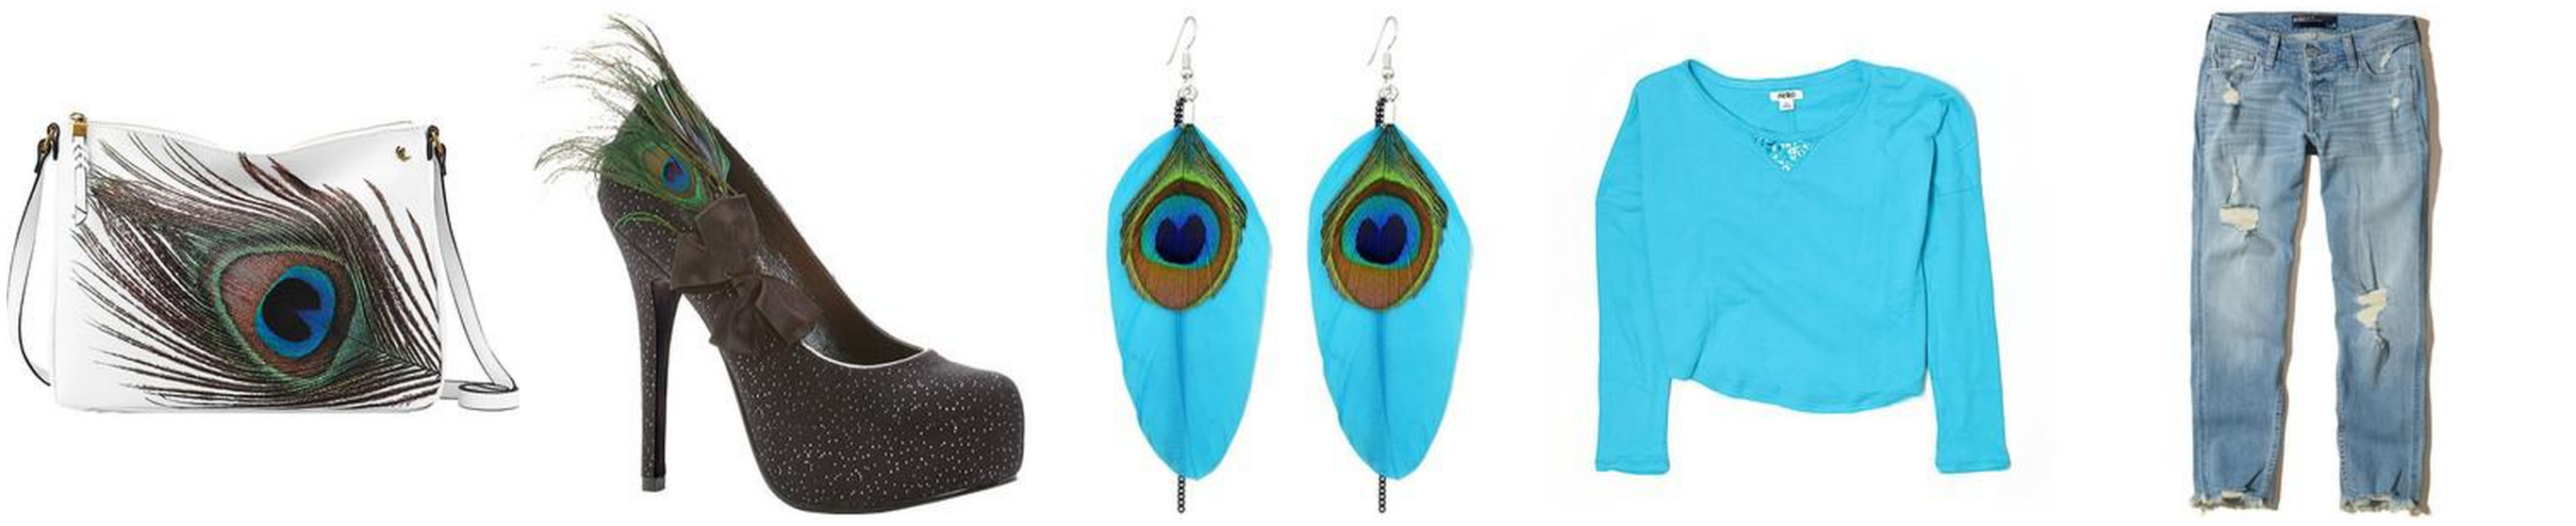

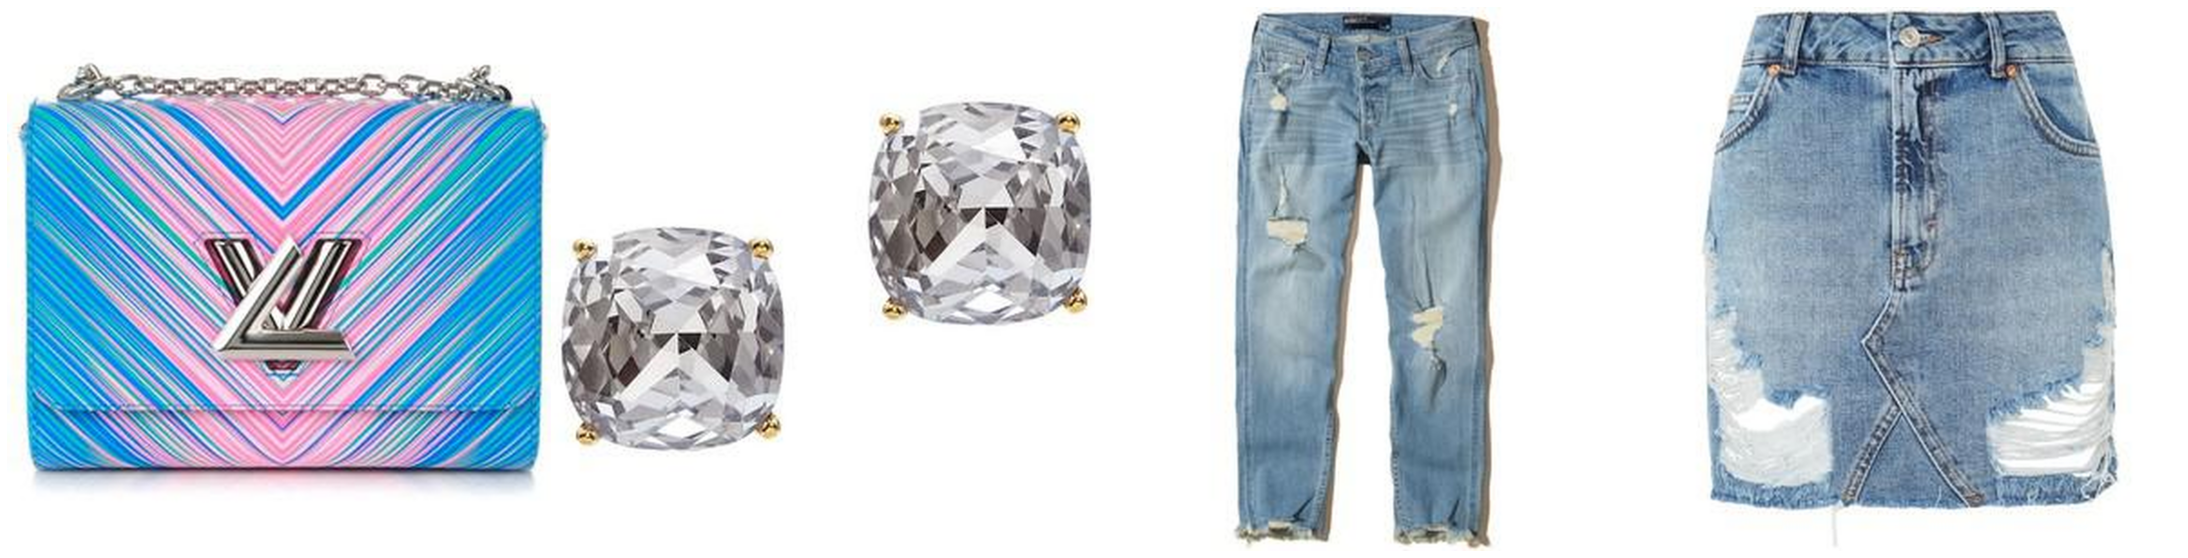

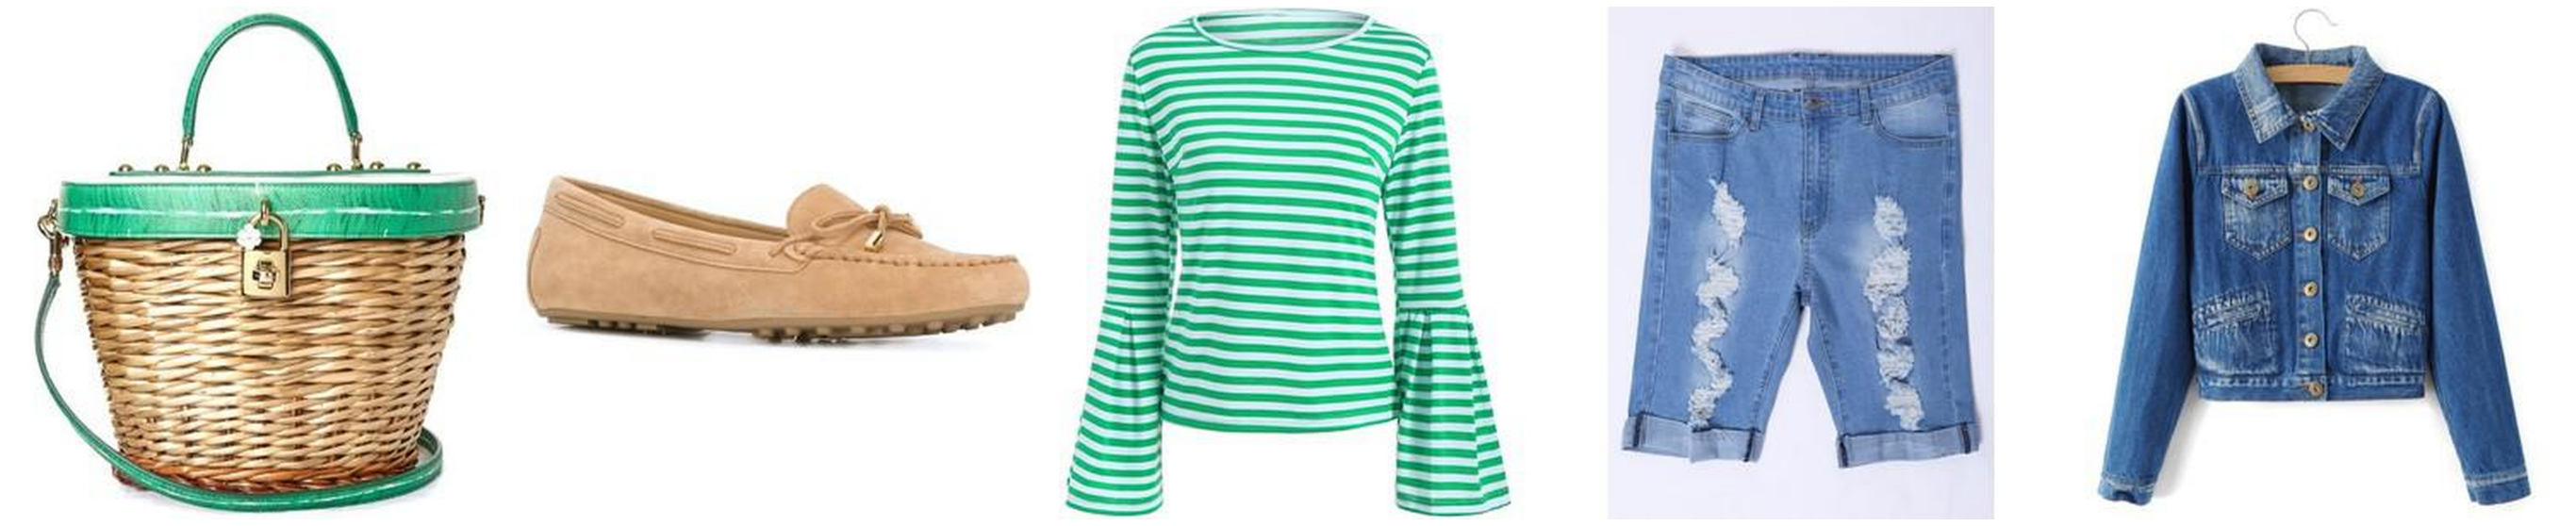

In [16]:
for board in boards:
    displayBoard(board)

### Return the style boards for the nearest items. Extract from inverted index